## Telling birds from airplanes using conv
For our CIFAR-10 data, we will resort to nn.Conv2d. At a minimum, the arguments we provide to nn.Conv2d are the number of input features, the number of output features, and the size of kernel. For instance, for our first convolutional module, we'll have 3 input features per pixel (RGB) and an arbitrary number of channels in the output-say, 16. The more channels in the output image, the more the capacity of the network. We need the channels to be able to detect many different types of features. Also, because we are randomly initializing them, some of the features we'll get, even after training, will turn out to be useless. Let's stick to a kernel size $3\times 3$.

In [1]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

For a single output pixel value, our kernel would consider, say in\_ch=3 input channels, so the weight component for a single output pixel value is of shape $in\_ch\times 3\times 3$. Finally, we have as many of those as we have output channels, here out\_ch=16, so the complete weight tensor is $out\_ch\times in\_ch \times 3\times 3$, in our case, $16\times 3\times 3\times 3$. The biase will have size 16. Let's verify:

In [2]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted sum over neighborhoods of the input image. In our case, both kernel weights and the bias conv.weight are initialized randomly, so the output image will not be particularly meaningful. As usual, we need to add the zeroth batch dimension with unsqueeze if we want to call the conv module with one input image, since nn.Conv2d expects a $B\times C\times H\times W$ shaped tensor as input:

In [8]:
from torchvision import datasets
from torchvision import transforms

data_path = '../../dlp_es/CIFAR-10/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                           transform=transforms.Compose([transforms.ToTensor(),
                                                         transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                              (0.2470, 0.2435, 0.2616))]))

cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                                                  (0.2470, 0.2435, 0.2616))]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]

cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [13]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

Display the output:

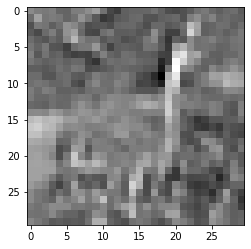

In [23]:
from matplotlib import pyplot as plt
import numpy as np

plt.imshow(output[0,0].detach(), cmap='gray')

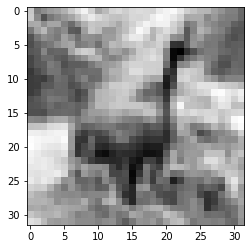

In [29]:
# input img
plt.imshow(img.unsqueeze(0)[0,0], cmap='gray')

In [30]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

### Dectecing features with convolutions
weight and bias are parameters that are learned through back-propagation. However, we can play with convolution by setting weights by hand and see what happens. Let's first zero out bias, just to remove any confounding factors, and then set weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each $3\times 3$ neighborhood:

In [33]:
import torch

with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

Let's see the effect on our CIFAR image:

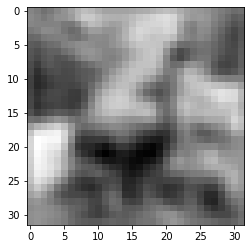

In [34]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')

As we can predict, the filter produces a blurred version of the image. After all, every pixel of the output is the average of a neightborhood of the input, so pixel in the output are correlated and change more smoothly.

edge-dectection kernel, have already been talked about in image processing.

Max pooling is provided by the nn.MaxPool2d module. It takes as input size of the neighborhood over which to operate the pooling operation. If we wish to downsample our image by half, we'll want to use a size of 2

In [36]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

Putting it all together for our network. Let's take our previous fully connected model as a starting point and introduce nn.Conv2d and nn.MaxPool2d as described previously:

In [38]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                      nn.Tanh(), 
                      nn.MaxPool2d(2),nn.Conv2d(16, 8, kernel_size=3, padding=1),
                      nn.Tanh(),
                      nn.MaxPool2d(2),
                      #
                      nn.Linear(8 * 8 * 8, 32),
                      nn.Tanh(),
                      nn.Linear(32, 2))

Where does this end? After the input image has been reduced to a set of $8\times 8$ features, we expect to output some probabilities from the network that we can feed to our negative log likelihood. However, probabilities are a pair of numbers in a 1D vector, but here we're still dealing with multichannel 2D features.

Let's count the number of parameters for this small model:

In [39]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [ ]:
model(img.unsqueeze(0))

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

What's missing here is the reshaping step from an 8-channel $8\times 8$ image to a 512-element, 1D vector. This could be achieved by calling $view$ on the output of the last nn.MaxPool2d, but unfortunately, we don't have any explicit visibility of the output each module when we use nn.Sequential

### Subclassing nn.Module
In this section, we learn how to make our own nn.Modules subclass that we can then use just like the prebuilt ones or nn.Sequential

In order to subclass nn.Module, at a minimum we need to define a $forward$ function that takes the inputs to the module and returns the output. This is where we define our module's computation. The name $forward$ here is reminiscent of a distant past, when module needed to define both forward and backward passes we met. With Pytorch, if we use standard $torch$ operations, $autograd$ will take care of the backward pass automatically, and indeed, an nn.Module never comes with a $backward$.

To include these submodules, we typically define them in the constructor \_\_init\_\_ and assign them to $self$ for use in the forward function.

In [43]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

Thus, the funcitonal way also sheds light on what the nn.Module API is all about: a Module is a container for state in the forms of $Parameters$ and submodules combined with the instructions to do a forward.

Now let's double-check the constructor, then we will get to the training loop.

In [45]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.2220, 0.1097]], grad_fn=<AddmmBackward>)

### Training our convnet
Recall that the core of our convnet is two nested loops: an outer one over the $epochs$ and an inner one of the $DataLoader$ that produces batches from our $Dataset$. In each loop, we have to:
1. Feed the inputs through the model (the forward pass)
2. Compute the loss (also the part of forward)
3. Zero any old gradients
4. Call loss.backward() to compute the gradients of the loss with respect to all parameters (the backward pass)
5. Have the optimizer take a step in toward lower loss

In [49]:
import torch.optim as optim
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(),
                                                         epoch,
                                                         loss_train / len(train_loader)))

In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss() 

training_loop(n_epochs = 100,
              optimizer = optimizer,
              model = model,
              loss_fn = loss_fn,
              train_loader = train_loader,)

2021-09-06 22:41:00.816004 Epoch 1, Training loss 0.5682625975578454
2021-09-06 22:41:18.529719 Epoch 10, Training loss 0.32345046178930126
2021-09-06 22:41:38.016864 Epoch 20, Training loss 0.29139912802322654
2021-09-06 22:41:57.327811 Epoch 30, Training loss 0.26563988364995667
2021-09-06 22:42:16.708650 Epoch 40, Training loss 0.24495113436963148
2021-09-06 22:42:35.975007 Epoch 50, Training loss 0.22590986625024467
2021-09-06 22:42:55.249463 Epoch 60, Training loss 0.20922158933748866
2021-09-06 22:43:14.592904 Epoch 70, Training loss 0.19498086217672203
2021-09-06 22:43:33.889939 Epoch 80, Training loss 0.17966891801471163
2021-09-06 22:43:53.245683 Epoch 90, Training loss 0.16475188395210133
2021-09-06 22:44:12.770232 Epoch 100, Training loss 0.1512153355084407
